# Create interactive plots for the entire NS5 protein
To do this, we will concatenate the relevant datasets that have been generated for each tile. This means the per-tile analysis must be run before this analysis can be completed. 

First, we will concatenate the 'host_adapt' charts for each tile, which includes average mutation effect and differential selection data for each site in both our Huh-7.5-selected and C6-36-selected conditions. Then we will re-plot in Altair, and regenerate a list of most interesting muts for each selection condition  

In [2]:
# import necessary Python modules and packages
import glob
import os
import subprocess
import shutil

import Bio.SeqIO

import dms_tools2
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as CBPALETTE
import dms_tools2.prefs
import dms_tools2.utils
print(f"Using dms_tools2 {dms_tools2.__version__}")

from IPython.display import display, HTML

import pandas as pd

import altair as alt
from plotnine import *

import numpy

import dms_variants.plotnine_themes

Using dms_tools2 2.6.10


Disable max rows in Altair. This was leading to bug in chart generation step. 

In [3]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Create dictionary of pandas dataframes for each host_adaptation.csv file in each tile's results folder. 

In [51]:
# create a pandas dataframe for each tile 'host_adapt.csv'
results = './results/'

d = {}

tile_list = ['tile_1', 'tile_2', 'tile_3', 'tile_4', 
             'tile_5', 'tile_6', 'tile_7', 'tile_8']

for tile in tile_list:
    tilepath = os.path.join(results + tile + "/host_adaptation/host_adaptation.csv")
    d[tile] = pd.read_csv(tilepath)


alltiles_hostadapt = pd.concat([d['tile_1'], d['tile_2'], d['tile_3'], d['tile_4'], 
                                d['tile_5'], d['tile_6'], d['tile_7'], d['tile_8']])

alltiles_hostadapt = (alltiles_hostadapt
                      # .replace(to_replace='conserved_site', value='conserved-site')
                     )
alltiles_hostadapt.mutation_type.unique()

array(['stop', 'all-others', 'conserved-site'], dtype=object)

Now we can save the concatenated file in a new results folder. 

In [5]:
# create 'all_tiles' file within results folder
alltiles_dir = './results/all_tiles'
os.makedirs(alltiles_dir, exist_ok=True)

# save concatenated dataframe as 'alltiles_host_adapt.csv'
alltiles_file = os.path.join(alltiles_dir + '/alltiles_host_adaptation.csv')
alltiles_hostadapt.to_csv(alltiles_file, index = False)
print('Saving concatenated data to "results/all_tiles/" folder. Here are first few lines...')
print(alltiles_hostadapt)

Saving concatenated data to "results/all_tiles/" folder. Here are first few lines...
      site wildtype mutant mutation  muteffect_C636  muteffect_Huh75  \
0        0        R      *      R0*         -6.5355          -6.5253   
1        0        R      A      R0A         -5.4941          -5.4757   
2        0        R      C      R0C         -6.5587          -6.5714   
3        0        R      D      R0D         -4.2456          -4.2537   
4        0        R      E      R0E         -4.6242          -4.6178   
...    ...      ...    ...      ...             ...              ...   
2389   903        L      S    L903S         -4.0944          -8.0479   
2390   903        L      T    L903T         -7.3498          -7.3545   
2391   903        L      V    L903V         -6.9133          -6.7640   
2392   903        L      W    L903W         -4.2839          -3.6808   
2393   903        L      Y    L903Y         -5.8816          -5.8905   

      foldchange_C636  foldchange_Huh75  diffsel_H

Now we can produce the Altair charts like we did for the per-tile analysis for the entire E gene

In [6]:
# select point nearest mouse
nearest = alt.selection(type='single', empty='none', nearest=True, on='mouseover')

# create the basic chart
basechart = (
 alt.Chart(alltiles_hostadapt
           .rename(columns={'muteffect_C636': 'effect C636',
                            'muteffect_Huh75': 'effect Huh75',
                            'diffsel_Huh75_vs_C636': 'Huh75 vs C636',
                            })
           .assign(dummy=0)
           )
 .add_selection(nearest)
 .encode(fill=alt.condition(nearest, alt.value('orange'), alt.value('gray')),
         opacity=alt.condition(nearest, alt.value(1), alt.value(0.4)),
         tooltip=['mutation', 'effect C636', 'effect Huh75', 'Huh75 vs C636'],
         color='mutation_type'
         )
 .interactive()
 )

# side-by-side interactive plots to select mutations
chart = (
 basechart.encode(x='effect C636:Q',
              y='effect Huh75:Q'
              )
      .mark_point()
      .properties(width=500,
                  height=500)
 |
 basechart.encode(x=alt.X('dummy:O', title=None),
              y='Huh75 vs C636:Q',           
              )
      .properties(width=50,
                  height=500)
      .mark_tick()
 )

# save the interactive plot
plotfile = os.path.join(alltiles_dir, 'select_muts_chart.html')
print(f"Saving interactive plot to {plotfile}")
chart.save(plotfile)

# show the chart
chart

Saving interactive plot to ./results/all_tiles/select_muts_chart.html


alt.HConcatChart(...)

The above interactive plots make it easy to identify mutations.

As mentioned above, Huh-7.5-specific mutations will:
  - have *effect Huh-7.5* $> 0$ in the scatter plot at left (be favorable in Huh-7.5 cells)
  - have *effect C636* $< 0$ in the scatter plot at left (be unfavorable in C636 cells)
  - have *Huh-7.5 vs C636* $> 0$ in the strip chart at right (be favored in Huh-7.5 over C636)
  
The C636-specific mutations will:
  - have *effect Huh-7.5* $< 0$ in the scatter plot at left (be unfavorable in Huh-7.5 cells)
  - have *effect C636* $> 0$ in the scatter plot at left (be favorable in C636 cells)
  - have *Huh-7.5 vs C636* $< 0$ in the strip chart at right (be favored in C636 over Huh-7.5)
  
You can use the mouse to hover over marks and they will turn orange in both the scatter plot and the strip chart, and a box will appear giving detailed information on the mutations.
You can also use the mouse scroll bar to zoom in and out.

*Note: the interactive plot will only render interactively in the Jupyter notebook itself! If you have a HTMl rendering the plot will be static. In that case, you want to open the interactive plot saved to the HTML file above separately.*

The best way to pick mutations will be to look at the charts above, but below we also simply list what appear to be some of the top candidates in tabular form using simple criteria.

In [7]:
print("The top Huh-7.5-specific mutations appear to be...")
display(HTML(
    alltiles_hostadapt
    .query('muteffect_Huh75 > 0')
    .sort_values('diffsel_Huh75_vs_C636', ascending=False)
    .head(n=20)
    .to_html(index=False)
    ))

print("The top C6-36-specific mutations appear to be...")
display(HTML(
    alltiles_hostadapt
    .query('muteffect_C636 > 0')
    .sort_values('diffsel_Huh75_vs_C636', ascending=True)
    .head(n=20)
    .to_html(index=False)
    ))

The top Huh-7.5-specific mutations appear to be...


The top C6-36-specific mutations appear to be...


## Make logoplot of mutational effects for Huh-7.5 NS5 
First we will write a file containing mutational effects for all tiles...

In [57]:
# Create directory for all-tile logoplots
alltiles_logodir = os.path.join(alltiles_dir, 'logoplots')
os.makedirs(alltiles_logodir, exist_ok=True)

# Make mutational effect file
for tile in tile_list:
    tilepath = os.path.join(results + tile + "/muteffects/Huh-7.5_muteffects.csv")
    d[tile] = pd.read_csv(tilepath)

alltiles_muteffects = pd.concat([d['tile_1'], d['tile_2'], d['tile_3'], d['tile_4'], 
                                d['tile_5'], d['tile_6'], d['tile_7'], d['tile_8']])
alltiles_muteffectsfile = os.path.join(alltiles_logodir, 'alltiles_muteffects.csv')
alltiles_muteffects.to_csv(alltiles_muteffectsfile, index=False)

# Make amino acid preferences file
for tile in tile_list:
    tilepath = os.path.join(results + tile + "/prefs/prefs_Huh-7.5.csv")
    d[tile] = pd.read_csv(tilepath)

alltiles_prefs = pd.concat([d['tile_1'], d['tile_2'], d['tile_3'], d['tile_4'], 
                                d['tile_5'], d['tile_6'], d['tile_7'], d['tile_8']])

# 'Add background back in at site 786'
alltiles_prefs.query('site == "786"').P
v = 0.97462
alltiles_prefs = alltiles_prefs.replace(v, v/100)

alltiles_prefsfile = os.path.join(alltiles_logodir, 'alltiles_prefs.csv')
alltiles_prefs.to_csv(alltiles_prefsfile, index=False)

In [59]:
name = 'NS5-Huh-7.5'

# Call dms2_logoplot for aa prefs
log = ! dms2_logoplot \
    --outdir {alltiles_logodir} \
    --ncpus 16 \
    --name {name} \
    --prefs {alltiles_prefsfile} \
    --use_existing 'no'

# Call dms2_logoplot for mutational preferences
log = ! dms2_logoplot \
    --outdir {alltiles_logodir} \
    --ncpus 16 \
    --name {name} \
    --muteffects {alltiles_muteffectsfile} \
    --use_existing 'no'

showing amino acid preferences for NS5 in Huh-7.5 cells...


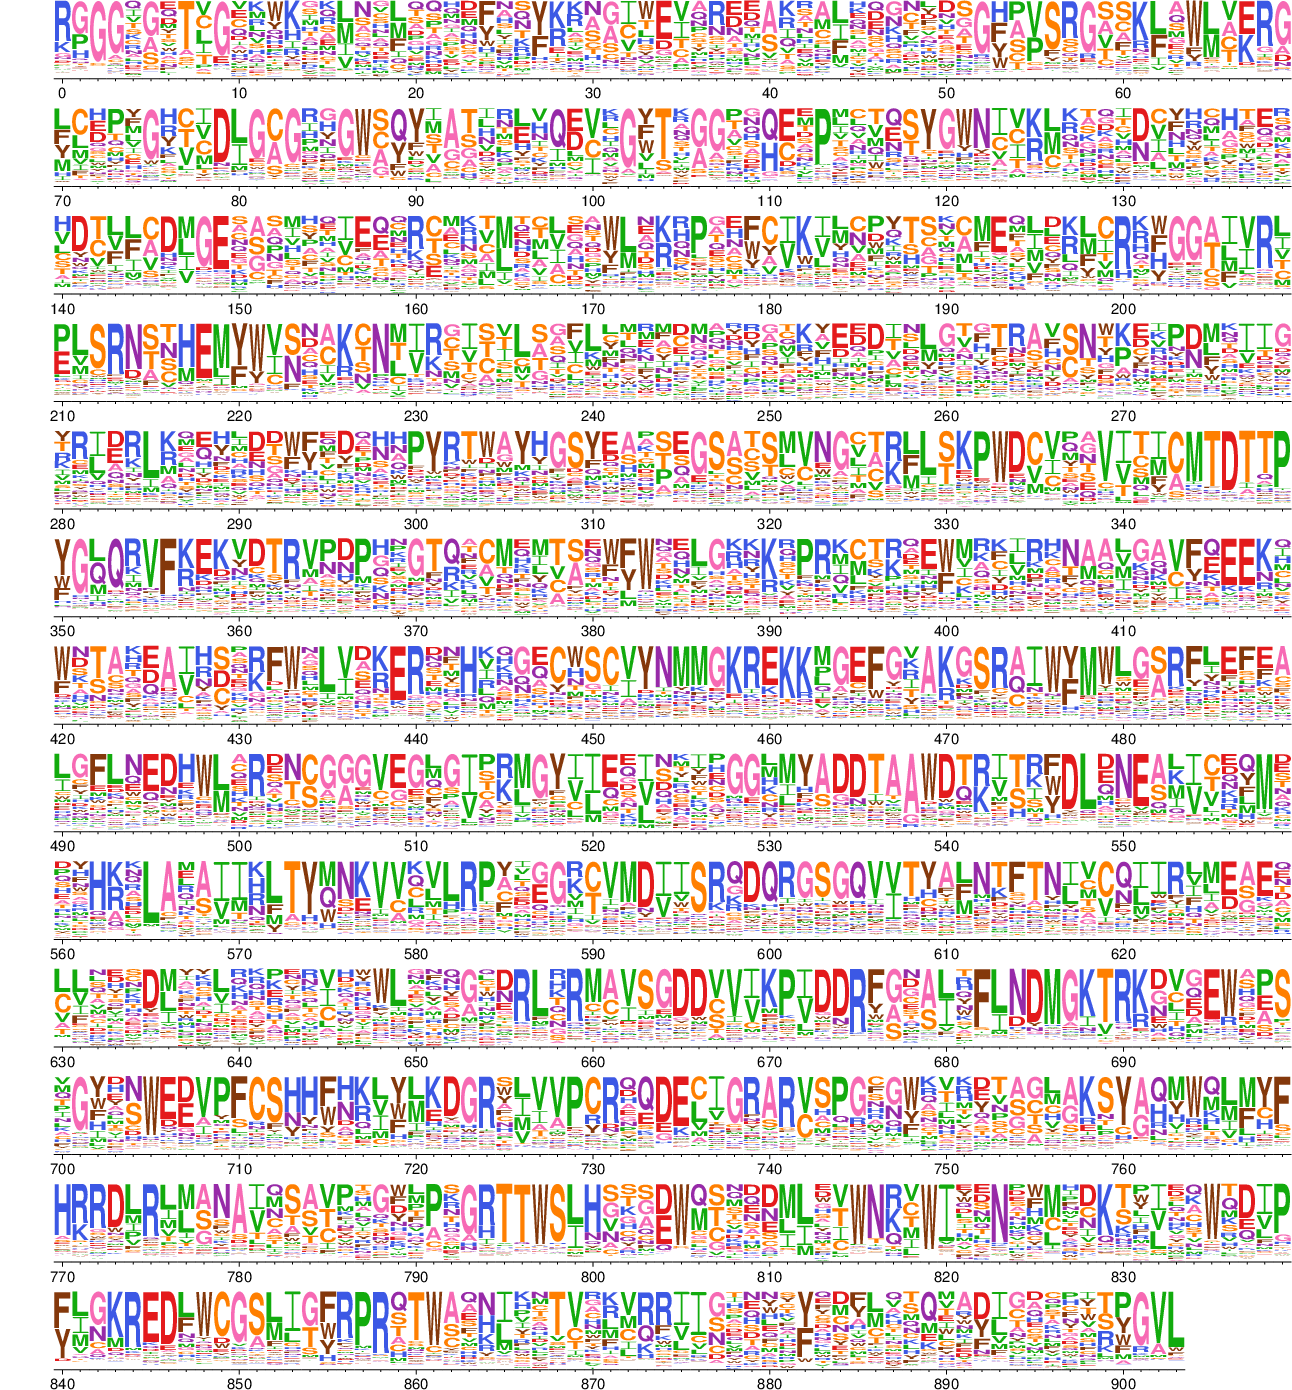

In [60]:
print('showing amino acid preferences for NS5 in Huh-7.5 cells...')
showPDF(os.path.join(alltiles_logodir, name + '_prefs.pdf'))

showing mutational tolerance for NS5 in Huh-7.5 cells...


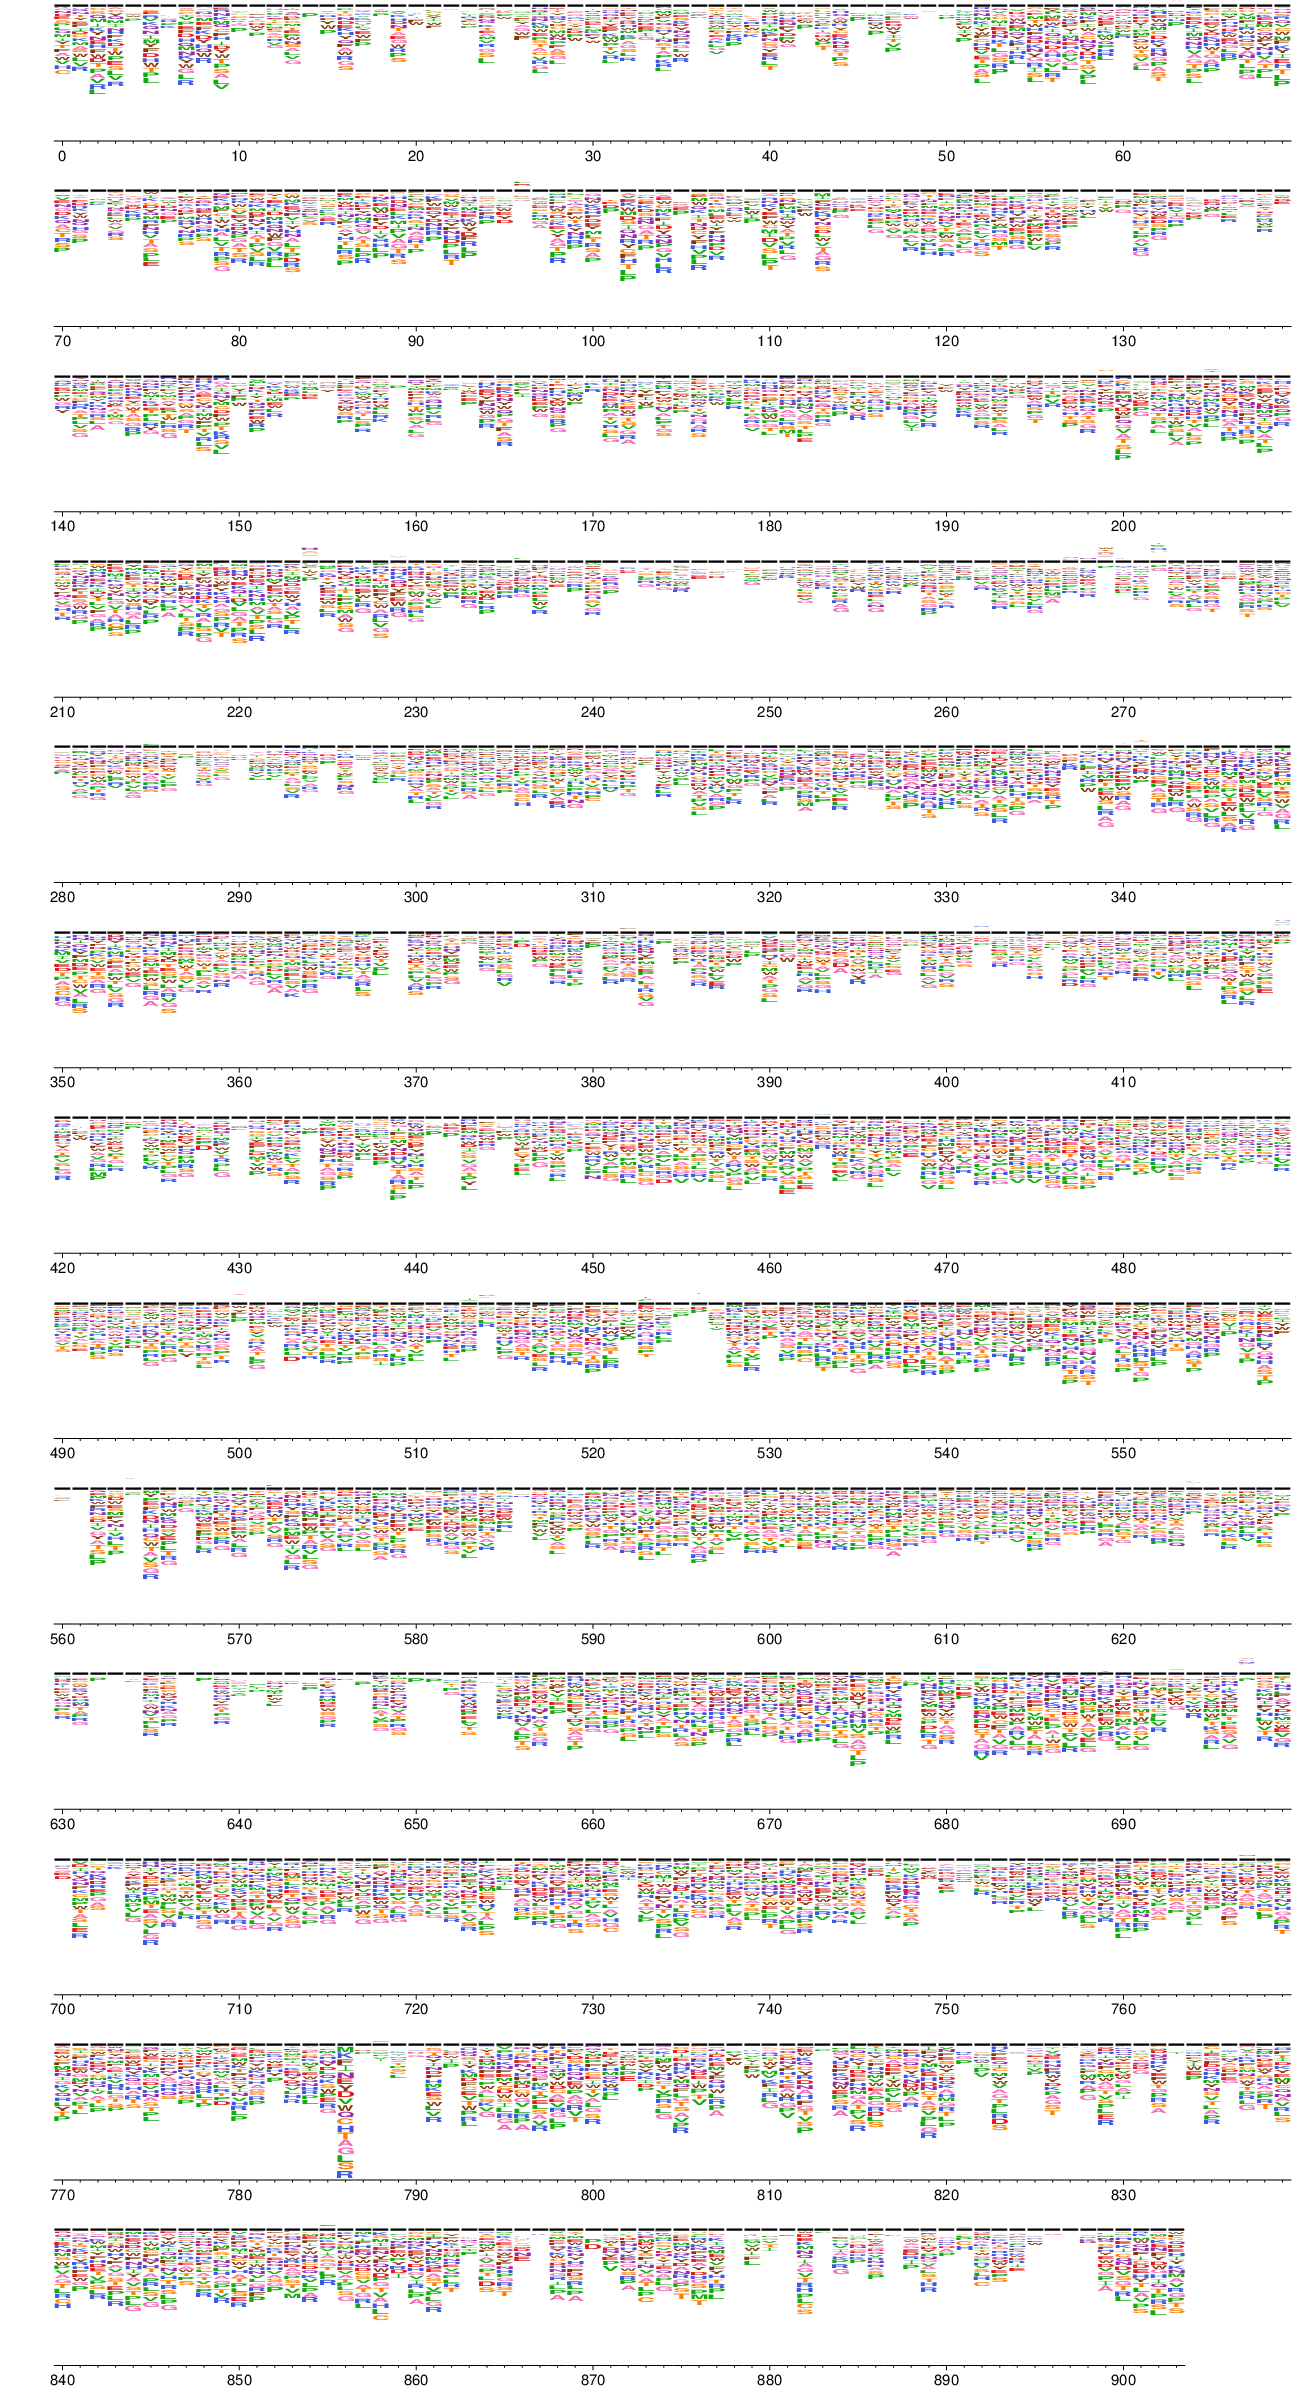

In [61]:
print('showing mutational tolerance for NS5 in Huh-7.5 cells...')
showPDF(os.path.join(alltiles_logodir, name + '_muteffects.pdf'))